In [57]:

import os
ROOT_DIRECTORY = os.path.abspath('')
os.chdir(ROOT_DIRECTORY)
random_seed = 42

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Union, Tuple
import copy
from scipy.stats import multivariate_normal
from types import SimpleNamespace
import math
from das.smc_utils import compute_ess_from_log_w, normalize_log_weights, resampling_function, normalize_weights, adaptive_tempering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(random_seed)

Using device: cuda


## Define Functions and Classes for Diffusion

In [30]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),  # 2D input + time
            nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2D output
        )

    def forward(self, x, t):
        x = torch.cat([x, t.unsqueeze(-1)], dim=-1)
        return self.net(x)

In [31]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

class DDIMScheduler:
    def __init__(self, num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_train_timesteps = num_train_timesteps
        
        self.betas = linear_beta_schedule(num_train_timesteps, beta_start, beta_end).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        self.final_alpha_cumprod = self.alphas_cumprod[0]
        self.num_inference_steps = None
        
    def set_timesteps(self, num_inference_steps):
        self.num_inference_steps = num_inference_steps
        self.timesteps = torch.linspace(self.num_train_timesteps - 1, 0, num_inference_steps, dtype=torch.long)
        
    def _get_variance(self, timestep, prev_timestep):
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            self.alphas_cumprod[prev_timestep],
            self.final_alpha_cumprod
        )
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        
        variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        return variance

In [32]:
def ddim_step_with_logprob(
    scheduler,
    model_output: torch.FloatTensor,
    timestep: int,
    sample: torch.FloatTensor,
    eta: float = 0.0,
    prev_sample: Optional[torch.FloatTensor] = None,
) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """
    Perform a single DDIM step with log probability calculation.
    
    Args:
        scheduler: The DDIMScheduler object.
        model_output: The output from the UNet model.
        timestep: The current timestep.
        sample: The current sample (x_t).
        eta: The eta parameter for adding noise (0 for DDIM, 1 for DDPM).
        prev_sample: Optional; the previous sample (x_{t-1}) if available.
    
    Returns:
        A tuple containing:
        - The previous sample (x_{t-1})
        - The log probability of the step
    """
    # 1. get previous step value (=t-1)
    prev_timestep = timestep - scheduler.num_train_timesteps // scheduler.num_inference_steps

    # 2. compute alphas, betas
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = torch.where(
        prev_timestep >= 0,
        scheduler.alphas_cumprod[prev_timestep],
        scheduler.final_alpha_cumprod
    )

    beta_prod_t = 1 - alpha_prod_t

    # 3. compute predicted original sample from predicted noise
    pred_original_sample = (sample - beta_prod_t.sqrt().unsqueeze(-1) * model_output) / alpha_prod_t.sqrt().unsqueeze(-1)
    
    # 4. compute variance
    variance = scheduler._get_variance(timestep, prev_timestep)
    std_dev_t = eta * variance.sqrt()

    # 5. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/fontsize10.02502.pdf
    pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt().unsqueeze(-1) * model_output

    # 6. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    prev_sample_mean = alpha_prod_t_prev.sqrt().unsqueeze(-1) * pred_original_sample + pred_sample_direction

    # 6. Add noise
    if prev_sample is None:
        noise = torch.randn(model_output.shape, device=device, dtype=model_output.dtype)
        prev_sample = prev_sample_mean + std_dev_t.unsqueeze(-1) * noise
    
    # 7. Compute log probability
    log_prob = _compute_gaussian_log_prob(prev_sample, prev_sample_mean, std_dev_t.unsqueeze(-1)).mean(-1)

    return prev_sample, log_prob

def _compute_gaussian_log_prob(x, mean, std):
    """Compute log probability for Gaussian distribution."""
    log_scale = torch.log(std)
    return -((x - mean) ** 2) / (2 * std ** 2) - log_scale - math.log(math.sqrt(2 * math.pi))

In [33]:
def ddim_step_KL(
    scheduler: DDIMScheduler,
    model_output: torch.FloatTensor,
    old_model_output: torch.FloatTensor,
    timestep: torch.LongTensor,
    sample: torch.FloatTensor,
    eta: float = 0.0,
    generator=None,
    variance_noise: Optional[torch.FloatTensor] = None,
) -> Union[Tuple[torch.FloatTensor, torch.FloatTensor], Tuple]:
    
    # 1. get previous step value (=t-1)
    prev_timestep = timestep - scheduler.num_train_timesteps // scheduler.num_inference_steps

    # 2. compute alphas, betas
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = torch.where(
        prev_timestep >= 0,
        scheduler.alphas_cumprod[prev_timestep],
        scheduler.final_alpha_cumprod
    )

    beta_prod_t = 1 - alpha_prod_t

    # 3. compute predicted original sample from predicted noise
    pred_original_sample = (sample - beta_prod_t.sqrt().unsqueeze(-1) * model_output) / alpha_prod_t.sqrt().unsqueeze(-1)
    old_pred_original_sample = (sample - beta_prod_t.sqrt().unsqueeze(-1) * old_model_output) / alpha_prod_t.sqrt().unsqueeze(-1)

    # 4. compute variance
    variance = scheduler._get_variance(timestep, prev_timestep)
    std_dev_t = eta * variance.sqrt()

    # 5. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt().unsqueeze(-1) * model_output
    old_pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt().unsqueeze(-1) * old_model_output

    # 6. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    prev_sample_mean = alpha_prod_t_prev.sqrt().unsqueeze(-1) * pred_original_sample + pred_sample_direction
    old_prev_sample_mean = alpha_prod_t_prev.sqrt().unsqueeze(-1) * old_pred_original_sample + old_pred_sample_direction

    if eta > 0 and timestep[0] > 0:
        device = model_output.device
        noise = torch.randn(model_output.shape, generator=generator, device=device, dtype=model_output.dtype)
        variance = std_dev_t.unsqueeze(-1) * noise

        prev_sample = prev_sample_mean + variance
        # print((prev_sample_mean - old_prev_sample_mean))
        kl_terms = (prev_sample_mean - old_prev_sample_mean)**2 / (2 * (std_dev_t**2).unsqueeze(-1))
        kl_terms = kl_terms.sum(dim=-1)  # Sum over the 2D dimensions
        # print(kl_terms)
    else:
        prev_sample = prev_sample_mean
        kl_terms = torch.zeros(prev_sample_mean.size(0), device=prev_sample_mean.device)

    # 7. Compute log probability
    log_prob = _compute_gaussian_log_prob(prev_sample, prev_sample_mean, std_dev_t.unsqueeze(-1)).mean(-1)

    return prev_sample, log_prob, kl_terms

In [34]:
@torch.no_grad()
def ddim_sample(model, scheduler, n, device, eta=1.0):
    x = torch.randn((n, 2)).to(device)
    
    for i, t in enumerate(scheduler.timesteps):
        t_tensor = torch.full((n,), scheduler.timesteps[i], device=device) # torch.full((n,), t, device=device).long()
        model_output = model(x, t_tensor / scheduler.num_train_timesteps)
        x, _, _ = ddim_step_KL(scheduler, model_output, 0., t_tensor, x, eta)
    
    return x

## Define Data Distribution (Mixture of Gaussians)

In [35]:
# Generate data from mixture of 2D Gaussians
def sample_gaussian_mixture(n_samples, means, covs):
    n_gaussians = len(means)
    samples = []
    for _ in range(n_samples):
        idx = np.random.randint(0, n_gaussians)
        sample = np.random.multivariate_normal(means[idx], covs[idx])
        samples.append(sample)
    return np.array(samples)

n_samples = 100000
# means = [(-2, -2), (2, 2), (-2, 2), (2, -2)]
# means = [(-3, 0), (3, 0), (-3, -3), (3, -3), (-3, 3), (3, 3)]
# means = [(-2, 6), (2, 6), (-2, -2), (2, 2), (-2, 2), (2, -2), (-2, -6), (2, -6)]

means = [
    (-4, 4), (0, 4), (4, 4),
    (-4, 0), (0, 0), (4, 0),
    (-4, -4), (0, -4), (4, -4),
]

# means = [
#     (-6, 6), (-2, 6), (2, 6), (6, 6),
#     (-6, 2), (-2, 2), (2, 2), (6, 2),
#     (-6, -2), (-2, -2), (2, -2), (6, -2),
#     (-6, -6), (-2, -6), (2, -6), (6, -6),
# ]

#means = [
#     (-4, 0), (-2*math.sqrt(2), 2*math.sqrt(2)), (0, 4), (2*math.sqrt(2), 2*math.sqrt(2)),
#     (4, 0), (2*math.sqrt(2), -2*math.sqrt(2)), (0, -4), (-2*math.sqrt(2), -2*math.sqrt(2)),
# ]

# means = [
#     (-6, 0), (-3*math.sqrt(3), 3), (-3, 3*math.sqrt(3)),
#     (0, 6), (3, 3*math.sqrt(3)), (3*math.sqrt(3), 3),
#     (6, 0), (3*math.sqrt(3), -3), (3, -3*math.sqrt(3)),
#     (0, -6), (-3, -3*math.sqrt(3)), (-3*math.sqrt(3), -3),
# ]
covs = [[[0.3, 0], [0, 0.3]] for _ in range(len(means))]
data = sample_gaussian_mixture(n_samples, means, covs)
data = torch.FloatTensor(data).to(device)

## Pre-training

In [36]:
# Hyperparameters
num_train_timesteps = 1000

# Initialize scheduler
scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps, device=device)

# Initialize models and optimizer
pre_trained_model = SimpleUNet().to(device)
optimizer = optim.Adam(pre_trained_model.parameters(), lr=1e-3)

In [37]:
# Pre-training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    t = torch.randint(0, num_train_timesteps, (n_samples,), device=device).long()
    noise = torch.randn_like(data)
    noisy_data = scheduler.alphas_cumprod[t].sqrt().unsqueeze(-1) * data + \
                 (1 - scheduler.alphas_cumprod[t]).sqrt().unsqueeze(-1) * noise
    predicted_noise = pre_trained_model(noisy_data, t.float() / num_train_timesteps)
    loss = F.mse_loss(predicted_noise, noise)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Pre-training Epoch {epoch}, Loss: {loss.item()}")

Pre-training Epoch 0, Loss: 1.0337876081466675
Pre-training Epoch 100, Loss: 0.5730381011962891
Pre-training Epoch 200, Loss: 0.4930882751941681
Pre-training Epoch 300, Loss: 0.4446122944355011
Pre-training Epoch 400, Loss: 0.4310366213321686
Pre-training Epoch 500, Loss: 0.42452237010002136
Pre-training Epoch 600, Loss: 0.4162895977497101
Pre-training Epoch 700, Loss: 0.408476859331131
Pre-training Epoch 800, Loss: 0.40626686811447144
Pre-training Epoch 900, Loss: 0.4033912420272827


In [38]:
# Set the number of inference steps before fine-tuning and sampling
num_inference_steps = 100
scheduler.set_timesteps(num_inference_steps)

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [39]:
def compute_reward(x):
    if isinstance(x, torch.Tensor):
        x_squared = torch.clamp(x**2, max=10000)
        return - x_squared[:, 0] / 100 - x_squared[:, 1]
    else:
        x_squared = x**2
        x_squared = np.where(x_squared > 10000, 10000, x_squared)
        return - x_squared[:, 0] / 100 - x_squared[:, 1]

def compute_reward_(x):
    if isinstance(x, torch.Tensor):
        x_squared = torch.clamp((x - torch.tensor([0, 1]).to(device))**2, max=10000)
        return - x_squared[:, 0] - x_squared[:, 1] / 10
    else:
        x_squared = (x - np.array([0, 1]))**2
        x_squared = np.where(x_squared > 10000, 10000, x_squared)
        return - x_squared[:, 0] - x_squared[:, 1] / 10


kl_weight = 1.

In [40]:
def gaussian_mixture_pdf(x, means, covs, weights=None):
    n_gaussians = len(means)
    if weights is None:
        weights = np.ones(n_gaussians) / n_gaussians
    
    pdf = np.zeros(x.shape[0])
    for mean, cov, weight in zip(means, covs, weights):
        pdf += weight * multivariate_normal.pdf(x, mean=mean, cov=cov)
    
    return pdf

def target_distribution_pdf(x, means, covs, kl_weight):
    gmm_pdf = gaussian_mixture_pdf(x, means, covs)
    reward = compute_reward(x)
    return gmm_pdf * np.exp(reward / kl_weight)

# Generate target distribution samples
def sample_target_distribution(n_samples, means, covs, kl_weight):
    samples = []
    weights = []
    x_range = np.linspace(-8, 8, 1000)
    y_range = np.linspace(-8, 8, 1000)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    pdf_values = target_distribution_pdf(grid_points, means, covs, kl_weight)
    pdf_values /= np.sum(pdf_values)
    
    indices = np.random.choice(len(grid_points), size=n_samples, p=pdf_values)
    samples = grid_points[indices]
    
    return samples

target_samples = sample_target_distribution(10000, means, covs, kl_weight)

target_reward = compute_reward(torch.tensor(target_samples).to(device)).mean().item()
print(target_reward)

-0.2916020325911497


In [41]:
# Generate pre-trained samples
pre_trained_samples = ddim_sample(pre_trained_model, scheduler, 10000, device)


In [42]:
pre_trained_reward = compute_reward(pre_trained_samples).mean().item()
pre_trained_samples = pre_trained_samples.cpu().numpy()

## Approximate Guidance

In [43]:
#@torch.no_grad()
def guided_sampling(model, scheduler, n_samples, device, num_inference_steps=50, eta=0.0, rho=1):
    latents = torch.randn((n_samples, 2)).to(device)
    
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps.to(device)

    for i, t in enumerate(timesteps):
        prev_timestep = t - scheduler.num_train_timesteps // num_inference_steps

        # Compute alpha_prod_t and alpha_prod_t_prev
        alpha_prod_t = scheduler.alphas_cumprod[t].to(device)
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            scheduler.alphas_cumprod[prev_timestep],
            scheduler.final_alpha_cumprod
        )
        beta_prod_t = 1 - alpha_prod_t
        
        # Compute std_dev_t
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        std_dev_t = eta * variance.sqrt()

        with torch.enable_grad():
            latents = latents.detach().requires_grad_(True)
            time = torch.full((latents.shape[0],), t.item(), device=device, dtype=torch.float32)
            noise_pred = model(latents, time / scheduler.num_train_timesteps)

            pred_original_sample = (latents - beta_prod_t.sqrt() * noise_pred) / alpha_prod_t.sqrt()
            reward = compute_reward(pred_original_sample)
            
            approx_guidance = torch.autograd.grad(outputs=reward, inputs=latents, grad_outputs=torch.ones_like(reward))[0]
            
        approx_guidance = torch.nan_to_num(approx_guidance.detach())
        approx_guidance *= rho
        
        # Compute the predicted next sample mean
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt() * noise_pred
        prev_sample_mean = alpha_prod_t_prev.sqrt() * pred_original_sample + pred_sample_direction
        
        # Add noise based on std_dev_t
        noise = torch.randn_like(latents)
        prev_sample = prev_sample_mean + std_dev_t * noise
        
        
        prev_sample += approx_guidance
        latents = prev_sample
        
    return latents

In [44]:
rho = 1.0

In [45]:
guidance_samples = guided_sampling(
    pre_trained_model, scheduler, 10000, device, num_inference_steps=num_inference_steps, eta=1.0, rho=rho
)

In [46]:

guidance_reward = compute_reward(guidance_samples).mean().item()
guidance_samples = guidance_samples.detach().cpu().numpy()

## SMC

In [47]:
def smc_sampling(model, scheduler, n_samples, device, num_inference_steps=50, num_particles=100, 
                 resample_strategy='systematic', ess_threshold=0.5, 
                 tempering_gamma=1.,
                 eta=1.0, kl_coeff=1.0):
    latents = torch.randn((n_samples * num_particles, 2), device=device)
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps

    log_w = torch.zeros(n_samples * num_particles, device=device)
    all_latents = []
    all_log_w = []
    all_resample_indices = []
    ess_trace = []
    tempering_trace = []
    rewards_trace = []

    resample_fn = resampling_function(resample_strategy=resample_strategy, ess_threshold=ess_threshold)

    for i, t in enumerate(timesteps):
        if i>0:
            log_twist_func_prev = log_twist_func.clone()
        prev_timestep = t - scheduler.num_train_timesteps // num_inference_steps

        # Compute alpha_prod_t and alpha_prod_t_prev
        alpha_prod_t = scheduler.alphas_cumprod[t].to(device)
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            scheduler.alphas_cumprod[prev_timestep],
            scheduler.final_alpha_cumprod
        )
        beta_prod_t = 1 - alpha_prod_t
        
        # Compute std_dev_t
        variance = eta**2 * (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        std_dev_t = variance.sqrt()

        # Calculate tempering factor
        tempering_factor = min((1 + tempering_gamma)**i - 1, 1.)

        # Predict noise and calculate reward
        t_input = torch.full((latents.shape[0],), t.item() / scheduler.num_train_timesteps, device=device, dtype=torch.float32)
        
        # latents.requires_grad_(True)
        # noise_pred = model(latents, t_input)
        # pred_original_sample = (latents - (1 - scheduler.alphas_cumprod[t]).sqrt() * noise_pred) / scheduler.alphas_cumprod[t].sqrt()
        # rewards = compute_reward(pred_original_sample)

        # # Calculate approximate guidance
        # approx_guidance = torch.autograd.grad(rewards.sum(), latents, create_graph=False, retain_graph=False)[0]
        # approx_guidance_1 = approx_guidance.detach().clone()
        # latents = latents.detach()

        latents.requires_grad_(True)
        noise_pred = model(latents, t_input)
        pred_original_sample = (latents - (1 - scheduler.alphas_cumprod[t]).sqrt() * noise_pred) / scheduler.alphas_cumprod[t].sqrt()
        rewards = compute_reward(pred_original_sample)

        # Calculate approximate guidance
        approx_guidance = torch.autograd.grad(outputs=rewards, inputs=latents, grad_outputs=torch.ones_like(rewards))[0]
        latents = latents.detach()

        approx_guidance = torch.nan_to_num(approx_guidance) / kl_coeff

        # Apply tempering
        approx_guidance *= tempering_factor

        # Update log weights
        log_twist_func = tempering_factor * rewards / kl_coeff
        log_w += log_twist_func - log_twist_func_prev + log_prob_diffusion - log_prob_proposal if i>0 else 0.

        # Resample if necessary
        ess = compute_ess_from_log_w(log_w.view(n_samples, -1))
        ess_trace.append(ess.cpu())

        # Detach log_w before resampling
        resample_indices, is_resampled, new_log_w = resample_fn(log_w.detach().view(n_samples, -1))
        # print(resample_indices.shape)
        log_w = new_log_w.view(-1).to(device)

        latents = latents.view(n_samples, num_particles, 2)[torch.arange(n_samples, device=device).unsqueeze(1), resample_indices].view(-1, 2)
        noise_pred = noise_pred.view(n_samples, num_particles, 2)[torch.arange(n_samples, device=device).unsqueeze(1), resample_indices].view(-1, 2)

        all_resample_indices.append(resample_indices)

        # Store latents and update rewards trace
        all_latents.append(latents.cpu())
        rewards_trace.append(rewards.view(n_samples, -1).max(dim=1)[0].cpu())

        # Sample from proposal distribution
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2).sqrt() * noise_pred
        prev_sample_mean = alpha_prod_t_prev.sqrt() * pred_original_sample + pred_sample_direction
        latents = prev_sample_mean + std_dev_t * torch.randn_like(noise_pred)
        latents += variance * approx_guidance

        log_prob_diffusion = -0.5 * (latents - prev_sample_mean).pow(2) / variance - torch.log(std_dev_t) - torch.log(torch.sqrt(2 * torch.as_tensor(math.pi)))
        log_prob_diffusion = log_prob_diffusion.sum(dim=-1) 
        log_prob_proposal = -0.5 * (latents - prev_sample_mean - variance * approx_guidance).pow(2) / variance - torch.log(std_dev_t) - torch.log(torch.sqrt(2 * torch.as_tensor(math.pi)))
        log_prob_proposal = log_prob_proposal.sum(dim=-1)

    # Final weight update
    final_rewards = compute_reward(latents)
    log_w += final_rewards / kl_coeff - log_twist_func + log_prob_diffusion - log_prob_proposal
    normalized_w = normalize_weights(log_w.view(n_samples, -1), dim=-1).view(-1)
    resample_indices, is_resampled, new_log_w = resample_fn(log_w.detach().view(n_samples, -1))
    latents = latents.view(n_samples, num_particles, 2)[torch.arange(n_samples, device=device).unsqueeze(1), resample_indices[:, torch.randperm(resample_indices.size(1))[:10]]].view(-1, 2)
    # latents = latents.view(n_samples, num_particles, 2)[:, torch.argmax(normalized_w.view(n_samples, num_particles), dim=-1)[1], :]

    ess_trace = torch.stack(ess_trace, dim=1) if ess_trace else torch.tensor([])
    tempering_trace = torch.tensor(tempering_trace, device=device)
    rewards_trace = torch.stack(rewards_trace, dim=1) if rewards_trace else torch.tensor([])

    return latents.detach()

In [48]:
num_particles = 100

In [49]:
smc_samples = smc_sampling(
    pre_trained_model, scheduler, n_samples=1000, device=device, num_inference_steps=num_inference_steps,
    num_particles=num_particles, resample_strategy='ssp', ess_threshold=.5,
    tempering_gamma=0.008,
    eta=1.0, kl_coeff=kl_weight
)

In [50]:
smc_reward = compute_reward(smc_samples).mean().item()
smc_samples = smc_samples.cpu().numpy()

## ISSGM (Importance Sampling via Score-based Generative Models)

In [51]:
def issgm(model, scheduler, n_samples, device, num_inference_steps=100,
                  eta=1.0, calib_phase=0.2, epsilon=1e-4, domain_min=-10., domain_max=10.):
    """
    Importance Sampling via Score-based Generative Models
    """
    
    latents = torch.randn((n_samples, 2), device=device)

    # Setup scheduler
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps
    #print("timesteps:", timesteps)
    # Track rewards for analysis
    rewards_trace = []

    for i, t in enumerate(timesteps):
        prev_timestep = t - scheduler.num_train_timesteps // num_inference_steps
        # Compute alpha_prod_t and alpha_prod_t_prev
        alpha_prod_t = scheduler.alphas_cumprod[t].to(device)
        alpha_prod_t_prev = torch.where(
            prev_timestep >= 0,
            scheduler.alphas_cumprod[prev_timestep],
            scheduler.final_alpha_cumprod
        )

        # Get alpha_t (single step alpha, not cumulative)
        alpha_t = scheduler.alphas[t].to(device)

        # Compute variance for standard diffusion step
        variance = eta ** 2 * (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)
        std_dev_t = variance.sqrt()  # torch.sqrt((1.0 - alpha_t) * (1. - alpha_prod_t_prev) / (1. - alpha_prod_t))

        # Get timestep input for model
        t_input = torch.full((latents.shape[0],), t.item() / scheduler.num_train_timesteps, device=device,
                             dtype=torch.float32)

        # Save original latents before any modifications
        original_latents = latents.detach().clone().requires_grad_(True)

        # Step 1: Get noise prediction from model (equivalent to epsilon in the alternative code)
        noise_pred = model(original_latents, t_input)

        # Step 2: Calculate the predicted original sample using noise prediction
        pred_original_sample = (original_latents - (1 - alpha_prod_t).sqrt() * noise_pred) / alpha_prod_t.sqrt()

        # Step 3: Compute reward/likelihood for predicted sample
        pred_original_sample.requires_grad_(True)
        rewards = compute_reward(pred_original_sample)
        rewards_trace.append(rewards.detach().cpu())

        # Step 4: Calculate gradient of log-likelihood w.r.t. pred_original_sample
        # Using log(reward) similar to alternative implementation
        #pre_log_loss = torch.exp(rewards)  # Similar to alternative implementation's loss function

        grad_log_l_x0 = torch.autograd.grad(
            outputs=rewards.sum(),
            inputs=pred_original_sample,
            create_graph=True
        )[0]

        # Scale gradient appropriately
        grad_log_l_x0 = torch.nan_to_num(grad_log_l_x0)

        # Step 5: Compute the score function for original latents
        # score = -noise_pred / sqrt(1 - alpha_prod_t)
        score = -noise_pred / (1 - alpha_prod_t).sqrt()

        # Step 6: Compute perturbed latents for Hessian approximation
        perturbed_latents = original_latents + epsilon * grad_log_l_x0
        perturbed_noise_pred = model(perturbed_latents, t_input)

        # Compute score at perturbed point
        perturbed_score = -perturbed_noise_pred / (1 - alpha_prod_t).sqrt()

        # Step 7: Approximate Hessian-vector product using score difference
        hessian_vector_approx = (perturbed_score - score) / epsilon

        # Step 8: Apply scaling factor for second term - matches alternative implementation
        #total_coefficient = (1.0 - alpha_t) / (alpha_t.sqrt() * alpha_prod_t.sqrt())
        total_coefficient = ((1.0 - alpha_prod_t) / alpha_t.sqrt() - (1 - alpha_prod_t_prev - std_dev_t ** 2).sqrt() * (
                    1 - alpha_prod_t).sqrt()) * (1.0 / alpha_prod_t.sqrt())

        second_term = total_coefficient * (grad_log_l_x0 + (1.0 - alpha_prod_t) * hessian_vector_approx)

        # Detach all computation graph tensors
        second_term = second_term.detach()

        # Step 9: Sample from standard diffusion process
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t ** 2).sqrt() * noise_pred
        prev_sample_mean = alpha_prod_t_prev.sqrt() * pred_original_sample.detach() + pred_sample_direction
        latents = prev_sample_mean + std_dev_t * torch.randn_like(noise_pred)

        # Step 10: Apply the adjustment term directly to latents (like in alternative implementation)
        # Only apply after a few steps (similar to i >= 3 condition in alternative)
        latents = (latents + second_term) if i/num_inference_steps > calib_phase else latents
        latents = torch.clamp(latents, domain_min, domain_max)

    # Compute final rewards
    final_rewards = compute_reward(latents)

    # Convert rewards trace to tensor
    rewards_trace = torch.stack(rewards_trace, dim=1) if rewards_trace else torch.tensor([])

    return latents.detach(), rewards_trace, final_rewards


In [52]:
# Run issgm sampling
issgm_samples = issgm(
    pre_trained_model,
    scheduler,
    n_samples=10000,
    device=device,
    num_inference_steps=num_inference_steps,
    eta=1.0,
    epsilon=1e-4
)[0]  # Get only the latents, ignore rewards_trace and final_rewards


In [53]:

# Compute reward for SBIS samples
issgm_reward = compute_reward(issgm_samples).mean().item()

# Convert to numpy for further processing or visualization
issgm_samples = issgm_samples.cpu().numpy()

# Visualize Samples and Rewards

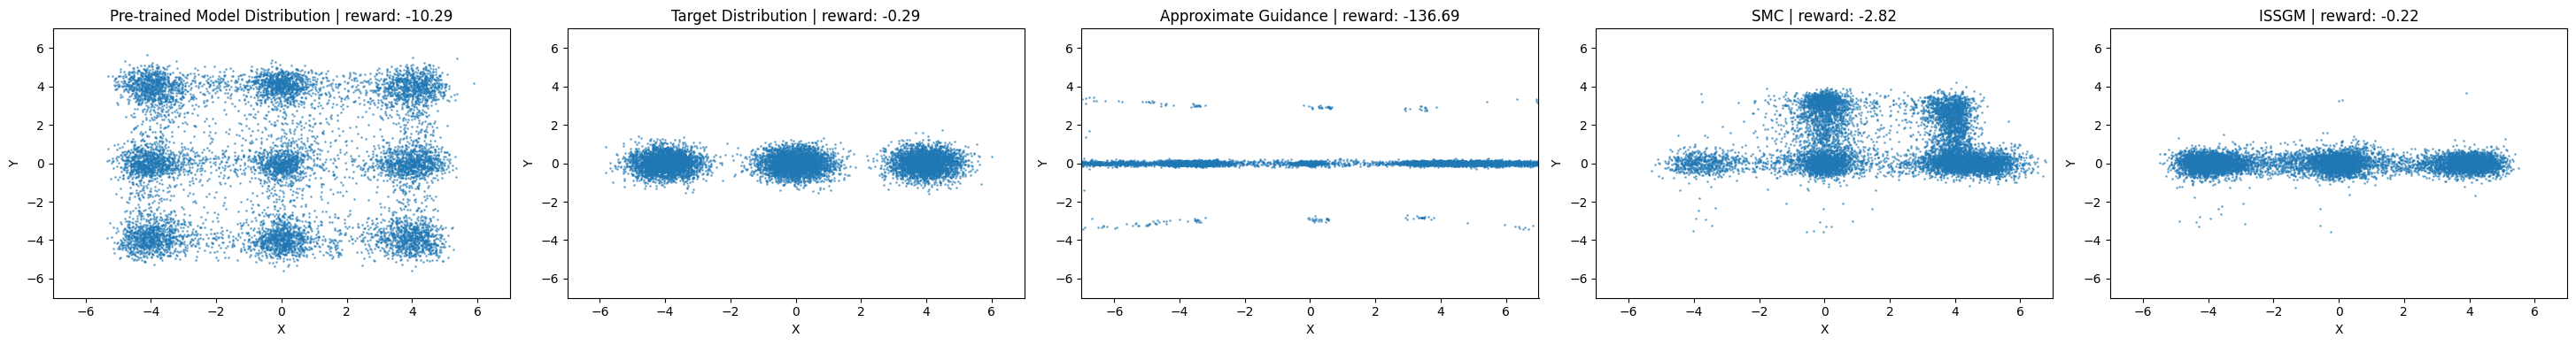

Figure saved as 'gaussian_mixture_1.png'


In [54]:
# Plot results
plt.figure(figsize=(35, 4))

# Set common axis limits
x_min, x_max = -7, 7
y_min, y_max = -7, 7

plt.subplot(1, 6, 1)
plt.scatter(pre_trained_samples[:, 0], pre_trained_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Pre-trained Model Distribution | reward: {pre_trained_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 2)
plt.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Target Distribution | reward: {target_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 3)
plt.scatter(guidance_samples[:, 0], guidance_samples[:, 1], alpha=0.5, s=1)
plt.title(f'Approximate Guidance | reward: {guidance_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.subplot(1, 6, 4)
plt.scatter(smc_samples[:, 0], smc_samples[:, 1], alpha=0.5, s=1)
plt.title(f'SMC | reward: {smc_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)



plt.subplot(1, 6, 5)
plt.scatter(issgm_samples[:, 0], issgm_samples[:, 1], alpha=0.5, s=1)
plt.title(f'ISSGM | reward: {issgm_reward:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()

# Save the figure
plt.savefig('gaussian_mixture_1.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

print("Figure saved as 'gaussian_mixture_1.png'")

In [55]:
from scipy.stats import wasserstein_distance_nd as WD
from numpy.random import choice


guidance_emd = WD(guidance_samples[choice(np.arange(len(guidance_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])
smc_emd = WD(smc_samples[choice(np.arange(len(smc_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])
issgm_emd = WD(issgm_samples[choice(np.arange(len(issgm_samples)), 500)], target_samples[choice(np.arange(len(target_samples)), 500)])

In [56]:
print("Wasserstein Distance guidance_emd:{}".format(guidance_emd))
print("Wasserstein Distance smc_emd:{}".format(smc_emd))
print("Wasserstein Distance ISSGM:{}".format(issgm_emd))

Wasserstein Distance guidance_emd:13.354159603378491
Wasserstein Distance smc_emd:2.2566484759678276
Wasserstein Distance ISSGM:0.24508863878932044
